**Model description:**

As latent variables, we have decided to use ones which deffer for different data points.

* $T$ - the left-upper pixels of villain's face images.
* $\Theta= (B,V,\epsilon)$, B - background picture, V - villain's face image, $\epsilon$ - noise parameter.
* $X$ - noisy data.

Params:

* H= 110
* W= 163
* K = 400
* h = 96
* w = 75



Let's introduce the next model:


$$p(x_i|t_j, \Theta) =\prod_{pixel \in [t_j,t_j+(h-1,w-1)]}N(x_{i_{pixel}} - V_{pixel-t_j}|0,\epsilon^2)\prod_{pixel \notin [t_j,t_j+(h-1,w-1)]}N(x_{i_{pixel}} - B_{pixel}|0,\epsilon^2)$$


Therefore, $p(x_i|t_j, \Theta) = N(x_i|\mu(t_j,\Theta),\Sigma(t_j,\Theta))$

Let's introduce new variables to sumplify our EM formulas:

$z_i \in \{0,1\}: \forall i  \in (H-h+1)\times(W-w+1) \, \sum_iz_i=1$

**E-step:**


$$q(t_j,x_i) = q_i(t_j) = p(t_j|x_i,\Theta) = \frac{p(x_i|t_j,\Theta)p(t_j|\theta)}{\sum_jp(x_i|t_j,\Theta)p(t_j|\theta)} $$

Here, we suppose the following (but we actually can tune it too):

$$p(t_j|\theta) = p(t_j) = \frac{1}{(H-h+1)(W-w+1)}$ $

**M-step:**

$$E_qlog(p(X,T|\Theta)) -> max_{\Theta}$$

$$E_qlog(p(X,T|\Theta)) = E_qlog(\prod_i\prod_jp(x_i,t_j|\Theta)) = E_qlog(\prod_i\prod_jp(x_i|t_j,\Theta)p(t_j|\Theta)) =
E_q(log(\prod_i\prod_jp(x_i|t_j,\Theta) + log(\prod_jp(t_j|\Theta)))$$

$$E_q(log(\prod_i\prod_jp(x_i|t_j,\Theta) + log(\prod_jp(t_j)) -> max_{\Theta}$$

$$E_qlog(\prod_i\prod_jp(x_i|t_j,\Theta) -> max_{\Theta}$$

$$\sum_i\sum_jq_i(t_j)p(x_i|t_j,\Theta) -> max_{\Theta}$$

$$\sum_i\sum_jq_i(t_j)N(x_i|\mu(t_j,\Theta),\Sigma(t_j,\Theta)) -> max_{\Theta=(B,V,\epsilon)}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import copy
% matplotlib inline

In [2]:
data = np.load('CameraData.npy')

In [3]:
data.shape

(110, 163, 400)

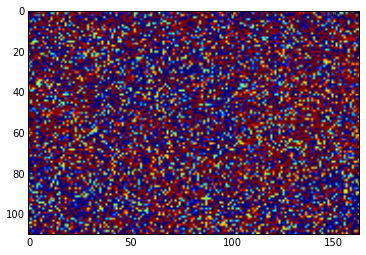

In [4]:
plt.imshow(data[:,:,7])

In [5]:
a = np.arange(0,12,1).reshape(2,3,2)

np.where(a[:,:] == a.max(axis=2))

/Users/Arseny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  app.launch_new_instance()


(array([], dtype=int64),)

In [6]:
a

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5]],

       [[ 6,  7],
        [ 8,  9],
        [10, 11]]])

In [7]:
np.newaxis?

In [8]:
np.fix?

In [10]:
from numpy import matlib

In [11]:
class ImageDetector():
    
    def __init__(self, H, W, h, w):
        self.H = H
        self.W = W
        self.h = h
        self.w = w
        
        
    def fit(self, X, tolerance=0.001, max_iter=50, restart=10):
       
        F_opt = None
        B_opt = None
        s_opt = None
        A_opt = None
        LL_opt = [-np.inf]
        self.N = X.shape[2]

        for i in range(restart):
            F, B, s, LL = self.EM(X, tolerance=tolerance, max_iter=max_iter)

            if LL[-1] > LL_opt[-1]:
                F_opt, B_opt, s_opt, LL_opt = F, B, s, LL
                
        return F_opt, B_opt, s_opt, LL_opt
    
    
    def EM(self, X, F=None, B=None, s=None, A=None, tolerance=0.001, max_iter=50):
      
        F = sps.randint.rvs(size=(self.h, self.w), low=0, high=256)       
        B = sps.randint.rvs(size=(self.H, self.W), low=0, high=256)    
        
        A = sps.uniform.rvs(size=(self.H - self.h + 1, self.W - self.w + 1))
        A = A / np.sum(A)
        
        s = sps.uniform.rvs(size=1, loc=0, scale=100)


        lpx_d_all = self.lpxt_theta(X, F, B, s)
        LL = []

        for n_iter in range(max_iter):
            
            # E-step
            q = self.e_step(X, F, B, s, A, lpx_d_all)
            
            # M-step
            F, B, s = self.m_step(X, q)
                
            # Calculate Variational Lower Bound
            lpx_d_all = self.lpxt_theta(X, F, B, s)
            LL.append(self.VLB(X, F, B, s, A, q, lpx_d_all))

            # Check stop criterion
            if n_iter > 0 and np.abs(LL[-1] - LL[-2]) < tolerance:
                break

        return F, B, s, LL
 
    

    def VLB(self, X, F, B, s, A, q, lpxt_theta_v=None):
      
        if lpxt_theta_v is None:
            lpxt_theta_v = self.lpxt_theta(X, F, B, s)
            
        L = 0
        for k in range(lpxt_theta_v.shape[2]):
            L += lpxt_theta_v[q[0, k], q[1, k], k] + np.log(A[q[0, k], q[1, k]])

        return L
    
    
    def lpxt_theta(self, X, F, B, s):
        

        L = np.zeros((self.H - self.h + 1, self.W - self.w + 1, self.N))
        X = X.transpose([2, 0, 1])

        # some constants for normal distribution for fast work
        const_add = -self.h * self.w * np.log(2 * np.pi * s ** 2) / 2
        const_mult = -1. / (2 * s ** 2)

        # cumulative sums for calculating sums in O(1)
        logpdf_B = -np.log(2 * np.pi * s ** 2) / 2 + const_mult * (X - B) ** 2
        cumsum_logpdf_B = np.cumsum(np.cumsum(logpdf_B, axis=1), axis=2)
        cumsum_logpdf_B = cumsum_logpdf_B.transpose([1, 2, 0])

        for dh in range(self.H - self.h + 1):
            for dw in range(self.W - self.w + 1):
                
                logpdf_F = ((X[:, dh:dh + self.h, dw:dw + self.w] - F) ** 2).sum(axis=(1, 2))
                L[dh, dw] = cumsum_logpdf_B[-1, -1] - cumsum_logpdf_B[dh + self.h - 1, dw + self.w - 1] \
                             + const_add + const_mult * logpdf_F
                if dh > 0:
                    L[dh, dw] += cumsum_logpdf_B[dh - 1, dw + self.w - 1]
                if dw > 0:
                    L[dh, dw] += cumsum_logpdf_B[dh + self.h - 1, dw - 1]
                if dh > 0 and dw > 0:
                    L[dh, dw] -= cumsum_logpdf_B[dh - 1, dw - 1]
        return L



    def e_step(self, X, F, B, s, A, lpx_d_all):

        alpha = lpx_d_all + np.matlib.repmat(np.log(A),1,self.N).T.reshape(self.H - self.h + 1, 
                                                                           self.W - self.w + 1, self.N)
        # the log-sum-exp trick to increase numerical stability:
        alpha = alpha - alpha.max(axis=(0, 1)) 
        alpha = np.exp(alpha)
        q = alpha / alpha.sum(axis=(0, 1))
        q_ = np.zeros((2, self.N))
        for k in range(self.N):   
            q_[:,k] = np.unravel_index(q[:,:,k].argmax(), q[:,:,k].shape) 
        return q_


    def m_step_F(self, X, q):
        faces = np.zeros((self.h, self.w))
        for k in range(self.N):
            faces += X[q[0, k]:q[0, k] + self.h, q[1, k]:q[1, k] + self.w, k]

        return faces / self.N


    def m_step_B(self, X, q):
        backgrounds = []
        for k in range(self.N):
            tx, ty = q[0, k], q[1, k]
            backgrounds.append(X[:,:,k].copy())
            backgrounds[-1][tx:tx + self.h, ty:ty + self.w] = np.nan

        return np.nanmean(backgrounds, axis=0)


    def m_step_s(self, X, q, F, B):

        total_var = 0.
        for k in range(self.N):
            tx, ty = q[0, k], q[1, k]
            face = X[tx:tx + self.h, ty:ty + self.w, k]
            var_face = np.power(face - F, 2).sum()
                        
            mask = np.ones((X.shape[0], X.shape[1]),dtype=bool)
            mask[tx:tx + self.h, ty:ty + self.w] = 0
            var_background = np.power(X[:, :, k].copy() - B, 2)[mask].sum()

            total_var += var_face + var_background

        return np.sqrt(total_var / (self.H * self.W * self.N))
    
    
    def m_step(self, X, q):
  
        F = self.m_step_F(X, q)
        B = self.m_step_B(X, q)
        s = self.m_step_s(X, q, F, B)

        return F, B, s

In [12]:
H, W, _ = data.shape
det = ImageDetector(H, W, 96, 75)
result = det.fit(data, max_iter=10, restart=1)

/Users/Arseny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:121: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Arseny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:131: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Arseny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:141: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Arseny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:145: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Arseny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:69: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
result[3]

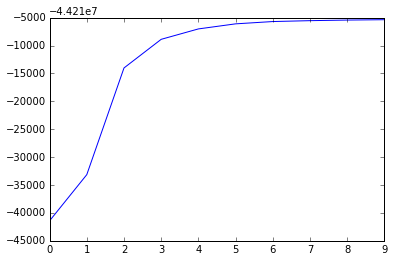

In [13]:
plt.plot(result[3])

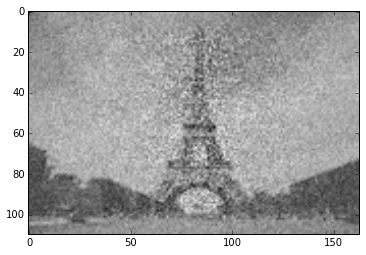

In [14]:
plt.imshow(result[1], cmap='gray')

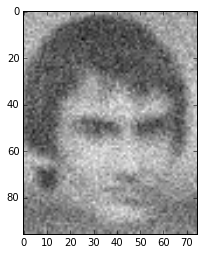

In [15]:
plt.imshow(result[0], cmap='gray')

In [ ]:
mean = data.sum(axis=2) / 400

In [ ]:
plt.imshow(mean, cmap='gray')

In [ ]:
plt.imshow(data[:,:,0:200].sum(axis=2) / 400, cmap='gray')

In [ ]:
plt.imsave('background.png',mean,cmap='gray')